<a href="https://colab.research.google.com/github/ik-ingkarat/229352-StatisticalLearning/blob/main/Lab02_Data_Preprocessing_660510782.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ศิวกร วังวล 650510736

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# For Fashion-MNIST
from tensorflow.keras.datasets import fashion_mnist

# For 20 Newsgroups
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## Part 1: Marketing Campaign Dataset - Manual Data Preprocessing & Logistic Regression

### Load the Marketing Campaign Dataset ([Data Information](https://archive.ics.uci.edu/dataset/222/bank+marketing))

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (`'yes'`) or not (`'no'`) subscribed.

In [ ]:
# URL for the raw Bank Marketing dataset CSV
bank_url = 'https://raw.githubusercontent.com/donlap/ds352-labs/main/bank.csv'

# Load the dataset
# - sep=';' is crucial as it's semicolon-separated
# - na_values=['unknown'] converts 'unknown' strings to NaN
df = pd.read_csv(bank_url, sep=';', na_values=['unknown'])
df = df.drop(["emp.var.rate", "cons.price.idx", "cons.conf.idx",	"euribor3m", "nr.employed"], axis=1)
print("Shape of the dataset:", df.shape)
df.head()

Shape of the dataset: (41188, 16)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,no


### Data Exploration

In [ ]:
# Check for missing values
print("--- Missing Values Count ---")
print(df.isnull().sum())

--- Missing Values Count ---
age               0
job             330
marital          80
education      1731
default        8597
housing         990
loan            990
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
y                 0
dtype: int64


In [ ]:
# Check unique values and counts for categorical columns
print("--- Unique Values for Categorical Columns ---")
for col in df.select_dtypes(include='object').columns:
    print(f"\n'{col}' unique values:")
    print(df[col].value_counts(dropna=False)) # Include NaN counts

--- Unique Values for Categorical Columns ---

'job' unique values:
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
NaN                330
Name: count, dtype: int64

'marital' unique values:
marital
married     24928
single      11568
divorced     4612
NaN            80
Name: count, dtype: int64

'education' unique values:
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
NaN                     1731
illiterate                18
Name: count, dtype: int64

'default' unique values:
default
no     32588
NaN     8597
yes        3
Name: count, dtype: int64

'housing' unique values:
housing
yes    21576
no     18622
NaN      990
Name: count, dtype: int64


### Data Preprocessing

In [ ]:
# Map target variable 'y' to 0 (no) and 1 (yes)
df['y'] = df['y'].map({'no': 0, 'yes': 1})

# Calculate class statistics
print(df['y'].describe())

# Drop 'duration' due to data leakage
df = df.drop('duration', axis=1)

# Define features (X) and target (y)
y = df['y']
X = df.drop('y', axis=1)

# Split the data BEFORE any transformations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print data shape
print(X_train.shape, X_test.shape)

count    41188.000000
mean         0.112654
std          0.316173
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: y, dtype: float64
(32950, 14) (8238, 14)


We will apply `StandardScaler()`, `OrdinalEncoder()`, and `OneHotEncoder()` on a few selected columns.

`StandardScaler` คือวิธีการปรับค่าตามค่าเฉลี่ย ใช้เมื่อ feature มีค่าต่างกันมากๆ เช่น อันนึงเป็นราคาบ้านหน่วยเป็นล้าน อีกอันเป็นขนาดที่ดิน (อันนี้จะทำให้ model เข้าใจผิด เเละให้ความสำคัญกับ feature ที่ค่ามากๆ )

**1. Numerical Feature: `age` and `campaign` (Standard Scaling)**

In [ ]:
# Select the columns for demonstration
num_cols_demo = ['age', 'campaign']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler ONLY on the training data
scaler.fit(X_train[num_cols_demo])

# Transform both training and test data
X_train_scaled_demo = scaler.transform(X_train[num_cols_demo])
X_test_scaled_demo = scaler.transform(X_test[num_cols_demo])

Let's take a look at the transformed `age` and `campaign` features and their statistics.

In [ ]:
print("\nOriginal X_train 'age' and 'campaign' head:")
print(X_train[num_cols_demo].head())
print("\nScaled X_train 'age' and 'campaign' head:")
print(pd.DataFrame(X_train_scaled_demo, columns=num_cols_demo, index=X_train.index).head())

print("\nMean of scaled 'age' (train):", X_train_scaled_demo[:, 0].mean())
print("Std Dev of scaled 'campaign' (train):", X_train_scaled_demo[:, 1].std())


Original X_train 'age' and 'campaign' head:
       age  campaign
12556   40         2
35451   31         4
30592   59         6
17914   43         5
3315    39         2

Scaled X_train 'age' and 'campaign' head:
            age  campaign
12556 -0.001669 -0.206242
35451 -0.864095  0.513676
30592  1.819007  1.233593
17914  0.285806  0.873635
3315  -0.097494 -0.206242

Mean of scaled 'age' (train): 2.2960557751155287e-16
Std Dev of scaled 'campaign' (train): 1.0


`OrdinalEncoder` คือวิธีการเข้ารหัสทั้งแบบ ตามอำเภอใจ และ แบบมีลำดับ วิธีที่ต้องการสามารถระบุได้โดยใช้พารามิเตอร์ encoding_method ที่ยอมรับทั้งแบบ "ตามอำเภอใจ" หรือ แบบมีลำดับ ถ้าไม่ได้กำหนด encoding_method จะใช้ค่าเริ่มต้นเป็น "ordered"

**2. Ordinal Feature: `education` (Ordinal Encoding with Imputation)**

- **Imputation**

In [ ]:
# Select the column for demonstration
ord_col_demo = ['education']

# Step 1: Impute missing values using SimpleImputer (most frequent strategy)
imputer_ord = SimpleImputer(strategy='most_frequent')

# Fit imputer only on training data
imputer_ord.fit(X_train[ord_col_demo])

# Fit imputer only on training AND test data
X_train_imputed_ord_demo = imputer_ord.transform(X_train[ord_col_demo])
X_test_imputed_ord_demo = imputer_ord.transform(X_test[ord_col_demo])

- **Ordinal Encoding**

In [ ]:
# Define the order for the 'education' ordinal feature
education_categories = [
    'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school',
    'professional.course', 'university.degree', 'masters', 'doctorate'
]

In [ ]:
# Step 2: Initialize OrdinalEncoder with the predefined categories
ordinal_encoder = OrdinalEncoder(categories=[education_categories])

# Fit the encoder ONLY on the imputed training data
ordinal_encoder.fit(X_train_imputed_ord_demo)

# Transform both imputed training and test data
X_train_ord_encoded_demo = ordinal_encoder.transform(X_train_imputed_ord_demo)
X_test_ord_encoded_demo = ordinal_encoder.transform(X_test_imputed_ord_demo)

Let's take a look at the imputed and ordinal-encoded `education`.

In [ ]:
print("\nOriginal X_train 'education' head:")
print(X_train[ord_col_demo].iloc[20:25])
print("\nImputed X_train 'education' head (after imputer.transform):")
print(pd.DataFrame(X_train_imputed_ord_demo, columns=ord_col_demo, index=X_train.index).iloc[20:25])
print("\nOrdinal Encoded X_train 'education' head:")
print(pd.DataFrame(X_train_ord_encoded_demo, columns=ord_col_demo, index=X_train.index).iloc[20:25])


Original X_train 'education' head:
                 education
919            high.school
33698             basic.9y
36871  professional.course
11438             basic.6y
28914    university.degree

Imputed X_train 'education' head (after imputer.transform):
                 education
919            high.school
33698             basic.9y
36871  professional.course
11438             basic.6y
28914    university.degree

Ordinal Encoded X_train 'education' head:
       education
919          4.0
33698        3.0
36871        5.0
11438        2.0
28914        6.0


`One-Hot encoding` คือ การ Encode ข้อมูล Categorical Data ที่ปกติเก็บเป็น Nomimal Number, Ordinal Number ให้แตกเป็น Column ย่อย ๆ แบบ Binary 0/1

**3. Nominal Feature: `job` (One-Hot Encoding with Imputation)**

- **Imputation**

In [ ]:
# Select the column for demonstration
nom_col_demo = ['job']

# Step 1: Impute missing values using SimpleImputer (most frequent strategy)
imputer_nom = SimpleImputer(strategy='most_frequent')
imputer_nom.fit(X_train[nom_col_demo]) # Fit imputer only on training data

X_train_imputed_nom_demo = imputer_nom.transform(X_train[nom_col_demo])
X_test_imputed_nom_demo = imputer_nom.transform(X_test[nom_col_demo])

- **Nominal Encoding**

In [ ]:
# sparse_output=False ensures a dense NumPy array is returned, easier for viewing
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit the encoder ONLY on the imputed training data
onehot_encoder.fit(X_train_imputed_nom_demo)

# Transform both imputed training and test data
X_train_onehot_encoded_demo = onehot_encoder.transform(X_train_imputed_nom_demo)
X_test_onehot_encoded_demo = onehot_encoder.transform(X_test_imputed_nom_demo)

In [ ]:
print("\nOriginal X_train 'job' head:")
print(X_train[nom_col_demo].iloc[40:45])
print("\nImputed X_train 'job' head (after imputer.transform):")
print(pd.DataFrame(X_train_imputed_nom_demo, columns=nom_col_demo, index=X_train.index).iloc[40:45])
print("\nOne-Hot Encoded X_train 'job' shape:", X_train_onehot_encoded_demo.shape)
print("First 5 rows of One-Hot Encoded X_train 'job':")
print(pd.DataFrame(X_train_onehot_encoded_demo, columns=onehot_encoder.get_feature_names_out(nom_col_demo), index=X_train.index).iloc[40:45])


Original X_train 'job' head:
              job
9420       admin.
3584    housemaid
38935  technician
12555  management
24910      admin.

Imputed X_train 'job' head (after imputer.transform):
              job
9420       admin.
3584    housemaid
38935  technician
12555  management
24910      admin.

One-Hot Encoded X_train 'job' shape: (32950, 11)
First 5 rows of One-Hot Encoded X_train 'job':
       job_admin.  job_blue-collar  job_entrepreneur  job_housemaid  job_management  job_retired  job_self-employed  job_services  job_student  job_technician  job_unemployed
9420          1.0              0.0               0.0            0.0             0.0          0.0                0.0           0.0          0.0             0.0             0.0
3584          0.0              0.0               0.0            1.0             0.0          0.0                0.0           0.0          0.0             0.0             0.0
38935         0.0              0.0               0.0            0.0          

### **Exercise 1: Apply All Preprocessing & Train Logistic Regression**

Now, it's your turn to apply these preprocessing steps to *all* relevant columns and then train a Logistic Regression model.

**Instructions:**

1.  Look at the Variable Table in [this link](https://archive.ics.uci.edu/dataset/222/bank+marketing).
2. Make lists for `numerical_features`, `ordinal_features`, and `nominal_features`.
3. Preprocess the features. It is safer to make a copy of `X_train` using:
   ```
   X_train_copy = X_train.copy()
   X_test_copy = X_test.copy()
   ```
   and preprocess `X_train_copy` instead.

   **For nominal features, concat the one-hot encoded features using [`pd.concat(..., axis=1)`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) and drop the old nominal features from the dataframe.**
4. Train Logistic Regression on the preprocessed `X_train_copy` and `y_train`.
5. Evaluate the Model:
    *   Make predictions on the preprocessed `X_test_copy`.
    *   Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?


In [ ]:
# --- YOUR CODE FOR EXERCISE 1 STARTS HERE ---
df = pd.read_csv('/content/bank-full.csv', sep=';', na_values=['unknown'])
df['y'] = df['y'].map({'no': 0, 'yes': 1})

X = df.drop(columns='y')
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2.Make lists for numerical_features, ordinal_features, and nominal_features.
numerical_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
ordinal_features = ['education']
nominal_features = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# 3.Preprocess the features. It is safer to make a copy of X_train using:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

# --- Numerical: Standardize
scaler = StandardScaler()
scaler.fit(X_train_copy[numerical_features])
X_train_copy[numerical_features]  = scaler.transform(X_train_copy[numerical_features])
X_test_copy[numerical_features]  = scaler.transform(X_test_copy[numerical_features])

# --- Ordinal: Encode education manually
imputer_ord = SimpleImputer(strategy='most_frequent')
imputer_ord.fit(X_train_copy[ordinal_features])
X_train_copy[ordinal_features] = imputer_ord.transform(X_train_copy[ordinal_features])
X_test_copy[ordinal_features] = imputer_ord.transform(X_test_copy[ordinal_features])

edu_order = ['primary', 'secondary', 'tertiary']
ordinal_encoder = OrdinalEncoder(categories=[edu_order])
ordinal_encoder.fit(X_train_copy[ordinal_features])
X_train_copy[ordinal_features] = ordinal_encoder.transform(X_train_copy[ordinal_features])
X_test_copy[ordinal_features] = ordinal_encoder.transform(X_test_copy[ordinal_features])

# --- Nominal: One-hot encode
imputer_nom = SimpleImputer(strategy='most_frequent')
X_train_nom = pd.DataFrame(imputer_nom.fit_transform(X_train_copy[nominal_features]), columns=nominal_features, index=X_train_copy.index)
X_test_nom = pd.DataFrame(imputer_nom.transform(X_test_copy[nominal_features]), columns=nominal_features, index=X_test_copy.index)

onehot = OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore')
onehot.fit(X_train_nom)

X_train_onehot = pd.DataFrame(onehot.transform(X_train_nom), index=X_train_copy.index, columns=onehot.get_feature_names_out(nominal_features))
X_test_onehot = pd.DataFrame(onehot.transform(X_test_nom), index=X_test_copy.index, columns=onehot.get_feature_names_out(nominal_features))

# Drop old nominal columns and add encoded ones
X_train_copy = pd.concat([X_train_copy.drop(columns=nominal_features), X_train_onehot], axis=1)
X_test_copy = pd.concat([X_test_copy.drop(columns=nominal_features), X_test_onehot], axis=1)

# 4.Train Logistic Regression on the preprocessed X_train_copy and y_train.
model = LogisticRegression()
model.fit(X_train_copy, y_train)

# 5.Evaluate the Model:
y_pred = model.predict(X_test_copy)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7952
           1       0.65      0.33      0.44      1091

    accuracy                           0.90      9043
   macro avg       0.78      0.65      0.69      9043
weighted avg       0.88      0.90      0.88      9043



## Part 2: Fashion-MNIST Dataset - Image Classification

### Load Fashion-MNIST Dataset

The Fashion-MNIST dataset consists of 28x28 grayscale images of fashion items.

In [4]:
# Load the dataset
(fm_X_train, fm_y_train), (fm_X_test, fm_y_test) = fashion_mnist.load_data()

print(f"Fashion-MNIST Train data shape: {fm_X_train.shape}")
print(f"Fashion-MNIST Train labels shape: {fm_y_train.shape}")
print(f"Fashion-MNIST Test data shape: {fm_X_test.shape}")
print(f"Fashion-MNIST Test labels shape: {fm_y_test.shape}")

Fashion-MNIST Train data shape: (60000, 28, 28)
Fashion-MNIST Train labels shape: (60000,)
Fashion-MNIST Test data shape: (10000, 28, 28)
Fashion-MNIST Test labels shape: (10000,)


In [5]:
print(f"First image {fm_X_train[0]}")
print(f"First label {fm_y_train[0]}")

First image [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   

### Visualize Fashion-MNIST Images

Let's see what these images look like.

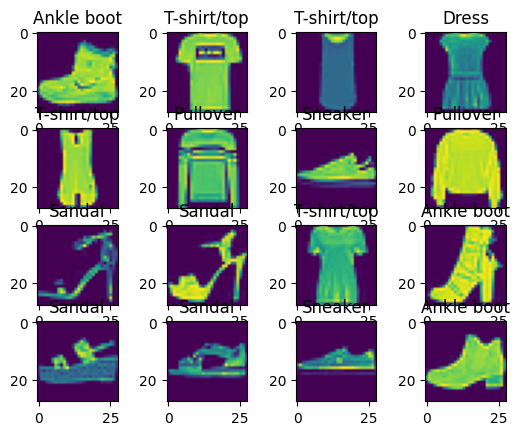

In [6]:
# Define class names (for better understanding)
fashion_mnist_class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Visualize the images
fig, axs = plt.subplots(4, 4)
for i, ax in enumerate(axs.flatten()): #flatten() แปลง vector 4*4 เป็น 16ยาว
    ax.imshow(fm_X_train[i])
    ax.set_title(fashion_mnist_class_names[fm_y_train[i]])

### **Exercise 2: Preprocessing Images (Flatten and Scale)**

Images are 2D arrays (matrices of pixels) and pixel values are integers from 0-255. For Logistic Regression, we need:
*  **Flattening:** Convert each 28x28 image into a 1D array of 784 features.
*  **Scaling:** Normalize pixel values from [0, 255] to [0, 1].

**Instructions:**

1.   **Flatten:** Use the `.reshape()` method (see [documentation](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.reshape.html)). For `fm_X_train_binary` (shape `(num_samples, 28, 28)`), you want to reshape it to `(num_samples, 28*28)`.
2.  **Scale:** Divide the flattened pixel values by 255.0 to get values between 0 and 1.
3.   **Train Logistic Regression:**
    *   Initialize `LogisticRegression(solver='saga')`. `saga` is a good solver when both number of samples and number of features are large.
    *   Fit the model on your *processed* `fm_X_train_scaled` and `fm_y_train`.
4.   **Make Predictions:** Use `predict()` to make predictions on the *processed* `fm_X_test_scaled`.
5.   **Print Classification Report:** Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?
6.   **Visualize Misclassifications:**
    *   Find the indices in `fm_X_test_binary` where your model made incorrect predictions (i.e., `fm_y_pred != fm_y_test`).
    *   Select 5 of these misclassified images.
    *   Plot these images (using `plt.imshow`). For each image, print its true label and its predicted label.

In [8]:
# --- YOUR CODE FOR EXERCISE 2 STARTS HERE ---
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Flatten the images
fm_X_train_flat = fm_X_train.reshape(fm_X_train.shape[0], -1)
fm_X_test_flat = fm_X_test.reshape(fm_X_test.shape[0], -1)

# Scale the pixel values to [0, 1]
fm_X_train_scaled = fm_X_train_flat / 255.0
fm_X_test_scaled = fm_X_test_flat / 255.0

# Initialize and train the model
model = LogisticRegression(solver='saga', max_iter=1000)
model.fit(fm_X_train_scaled, fm_y_train)
fm_y_pred = model.predict(fm_X_test_scaled)

print(classification_report(fm_y_test, fm_y_pred))


              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1000
           1       0.97      0.96      0.96      1000
           2       0.73      0.74      0.73      1000
           3       0.83      0.86      0.84      1000
           4       0.74      0.76      0.75      1000
           5       0.94      0.92      0.93      1000
           6       0.63      0.57      0.60      1000
           7       0.91      0.94      0.92      1000
           8       0.93      0.93      0.93      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



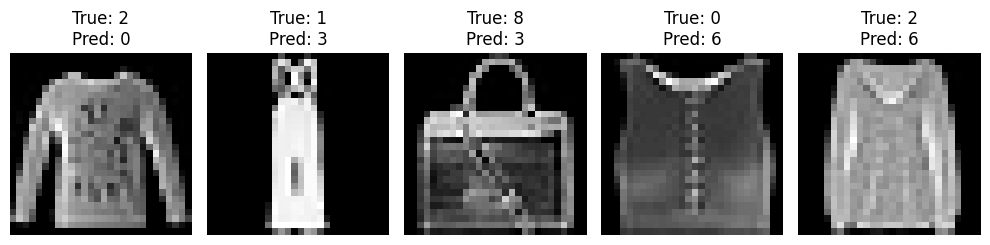

In [10]:
import matplotlib.pyplot as plt

# Find misclassified indices
misclassified_indices = np.where(fm_y_pred != fm_y_test)[0]

# Select 5 misclassified examples
selected_misclassified = np.random.choice(misclassified_indices, size=5, replace=False)

# Plot the misclassified images
plt.figure(figsize=(10, 5))
for i, idx in enumerate(selected_misclassified):
    plt.subplot(1, 5, i + 1)
    plt.imshow(fm_X_test[idx], cmap='gray')
    plt.title(f'True: {fm_y_test[idx]}\nPred: {fm_y_pred[idx]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


## Part 3: 20 Newsgroups Dataset - Text Classification

### Load 20 Newsgroups Dataset

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics.

In [11]:
# Load the training and testing data
news_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
news_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42)

X_train_news, y_train_news = news_train.data, news_train.target
X_test_news, y_test_news = news_test.data, news_test.target

print(f"Number of training documents: {len(X_train_news)}")
print(f"Number of test documents: {len(X_test_news)}")
print(f"Categories: {news_train.target_names}")

Number of training documents: 11314
Number of test documents: 7532
Categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


### Explore Sample Document

In [12]:
# Print the first document and its class
## Write your code here
X_train_news[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

### Preprocessing: Text Vectorization Demonstration with `TfidfVectorizer`

$$
\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$

Where:

$$
\text{TF}(t, d) = \frac{\text{number of word }t\text{ in } d}{\text{number of words in } d} \quad \text{ and } \quad
\text{IDF}(t, D) = \log\left(\frac{\text{total number of documents}}{\text{number of documents that contain word }t}\right).
$$

In [13]:
# Create a small list of sentences for demonstration
sample_sentences = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?"
]

# Initialize TfidfVectorizer for demonstration
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the sample sentences
# The output `sample_vec_output` will be a sparse matrix
sample_vec_output_sparse = vectorizer.fit_transform(sample_sentences)

# Convert to a dense NumPy array for easier viewing
sample_vec_output_dense = sample_vec_output_sparse.toarray()

print("\nVocabulary (word to index mapping):")
print(vectorizer.vocabulary_)

print("\nFeature names (words):")
print(vectorizer.get_feature_names_out())

print("\nTF-IDF matrix for sample sentences (dense format):")
print(sample_vec_output_dense)


Vocabulary (word to index mapping):
{'document': 0, 'second': 1}

Feature names (words):
['document' 'second']

TF-IDF matrix for sample sentences (dense format):
[[1.         0.        ]
 [0.78722298 0.61666846]
 [0.         0.        ]
 [1.         0.        ]]


### **Exercise 3: Apply TF-IDF Vectorization to Full Dataset**

Now, apply `TfidfVectorizer` to the actual training and testing datasets for the 20 Newsgroups classification task.

**Instructions:**

1.  **Initialize `TfidfVectorizer`:**
    *   Initialize `TfidfVectorizer`. Use `stop_words='english'` to remove common words.
2.  **Fit and Transform Training Data:**
    *   Call `fit_transform()` on `X_train_news` to learn the vocabulary and transform the training text into TF-IDF features. Store the result in `X_train_vec`.
3.  **Transform Test Data:**
    *   Call `transform()` on `X_test_news` using the *already fitted* vectorizer. Store the result in `X_test_vec`. **Crucially, do not call `fit_transform()` on the test data!** This would cause data leakage.
4.  **Initialize Logistic Regression:**
    *   Initialize `LogisticRegression(solver='saga')`. `saga` is a good solver when both number of samples and number of features are large.
5.  **Train the Model:**
    *   Fit the model on your `X_train_vec` and `y_train_news`.
6.  **Make Predictions:**
    *   Make predictions using `predict()` on the `X_test_vec`.
7.  **Evaluate the Model:**
    *   Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?

In [14]:
# --- YOUR CODE FOR EXERCISE 3 STARTS HERE ---
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Load train and test sets
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# Extract data and labels
X_train_news = newsgroups_train.data
y_train_news = newsgroups_train.target

X_test_news = newsgroups_test.data
y_test_news = newsgroups_test.target

# Initialize TF-IDF Vectorizer with English stop words removed
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the training data
X_train_vec = vectorizer.fit_transform(X_train_news)

# Only transform the test data (do NOT fit again)
X_test_vec = vectorizer.transform(X_test_news)

# Initialize Logistic Regression with the 'saga' solver
model = LogisticRegression(solver='saga', max_iter=1000)
model.fit(X_train_vec, y_train_news)
y_pred_news = model.predict(X_test_vec)

# Evaluate the model
print(classification_report(y_test_news, y_pred_news, target_names=newsgroups_test.target_names))


                          precision    recall  f1-score   support

             alt.atheism       0.49      0.45      0.47       319
           comp.graphics       0.63      0.71      0.67       389
 comp.os.ms-windows.misc       0.66      0.63      0.64       394
comp.sys.ibm.pc.hardware       0.68      0.65      0.66       392
   comp.sys.mac.hardware       0.75      0.69      0.72       385
          comp.windows.x       0.83      0.72      0.77       395
            misc.forsale       0.76      0.79      0.77       390
               rec.autos       0.75      0.71      0.73       396
         rec.motorcycles       0.48      0.81      0.61       398
      rec.sport.baseball       0.81      0.82      0.82       397
        rec.sport.hockey       0.90      0.86      0.88       399
               sci.crypt       0.89      0.67      0.76       396
         sci.electronics       0.56      0.61      0.59       393
                 sci.med       0.76      0.79      0.78       396
         